In [93]:
import numpy as np
import pandas as pd
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lifelines.datasets
import torch
import torchtuples as tt
from pycox.models import CoxPH, CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
np.random.seed(1998)
_ = torch.manual_seed(1998)

In [94]:
df = pd.read_csv("data_ready_wnw.csv")

In [95]:
def clean_data(df):
    # Replace all instances of "Y" with "0" in column: 'GRF_STAT_PA'
    df['GRF_STAT_PA'] = df['GRF_STAT_PA'].str.replace("Y", "0", case=False, regex=False)
    # Replace all instances of "N" with "1" in column: 'GRF_STAT_PA'
    df['GRF_STAT_PA'] = df['GRF_STAT_PA'].str.replace("N", "1", case=False, regex=False)
    # Change column type to float32 for column: 'GRF_STAT_PA'
    df = df.astype({'GRF_STAT_PA': 'float32'})
    return df

df = clean_data(df.copy())


In [96]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=654)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=654)

In [97]:
ssc = StandardScaler()
x_train = ssc.fit_transform(df_train.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_val = ssc.transform(df_val.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_test = ssc.transform(df_test.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')

In [98]:
get_target = lambda df: (df['time_frame'].values, df['GRF_STAT_PA'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [99]:
in_features = x_train.shape[1]
num_nodes = [1024, 512, 256, 128, 64]
out_features = 1
batch_norm = True
dropout = 0.3
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

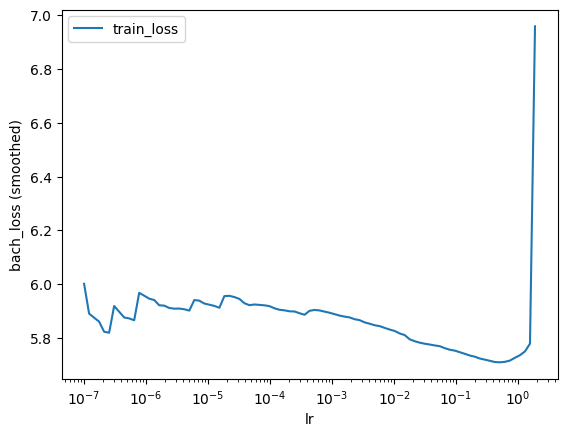

In [100]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 512
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [101]:
lrfinder.get_best_lr()

0.050941380148164093

In [102]:
model.optimizer.set_lr(0.05)

In [103]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 5.9104,	val_loss: 5.4942
1:	[1s / 3s],		train_loss: 5.5895,	val_loss: 5.0950
2:	[1s / 4s],		train_loss: 5.5126,	val_loss: 4.9551
3:	[1s / 6s],		train_loss: 5.5013,	val_loss: 5.0373
4:	[1s / 7s],		train_loss: 5.5312,	val_loss: 5.3208
5:	[1s / 8s],		train_loss: 5.5415,	val_loss: 5.2084
6:	[1s / 10s],		train_loss: 5.5018,	val_loss: 5.0481
7:	[1s / 11s],		train_loss: 5.4279,	val_loss: 4.9816
8:	[1s / 12s],		train_loss: 5.4124,	val_loss: 4.9849
9:	[1s / 13s],		train_loss: 5.4059,	val_loss: 4.9817
10:	[1s / 14s],		train_loss: 5.3723,	val_loss: 5.0027
11:	[1s / 15s],		train_loss: 5.3446,	val_loss: 4.9820
12:	[1s / 16s],		train_loss: 5.3267,	val_loss: 4.9700


c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

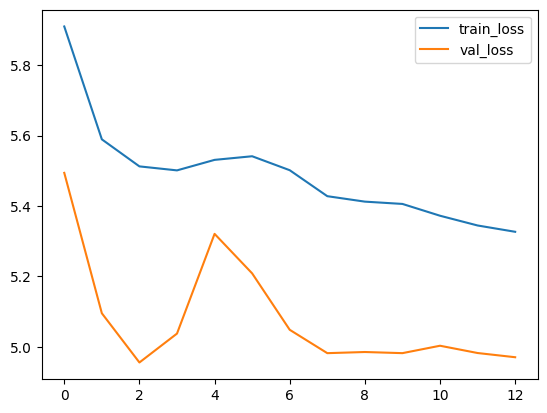

In [104]:
_ = log.plot()

In [105]:
model.partial_log_likelihood(*val).mean()

-7.4227796

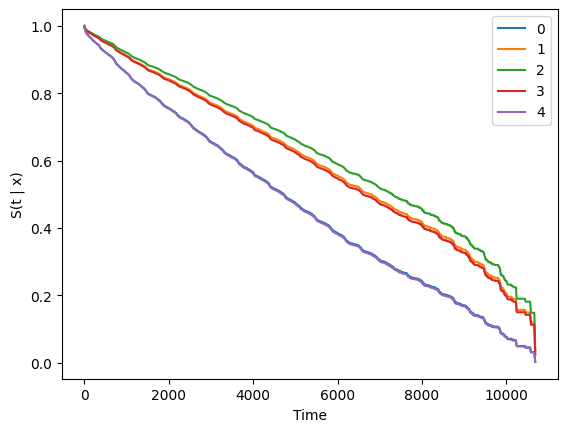

In [106]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [107]:
df.loc[df_test.index[:5]]

,GENDER_F,GENDER_M,ABO_A,ABO_A1,ABO_A1B,ABO_A2,ABO_A2B,ABO_AB,ABO_B,ABO_O,...,PROTEIN_URINE_U,PROTEIN_URINE_Y,CARDARREST_NEURO_N,CARDARREST_NEURO_U,CARDARREST_NEURO_Y,RESUSCIT_DUR,INOTROP_SUPPORT_DON_N,INOTROP_SUPPORT_DON_U,INOTROP_SUPPORT_DON_Y,time_frame
23264,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1471
22997,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,2249
20193,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,4008
4911,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4744
2527,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,7123


In [108]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

In [109]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [110]:
ev.concordance_td()

0.6655652416751512

In [111]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [112]:
ev.integrated_brier_score(time_grid=time_grid)

0.17424256783740563

In [ ]:
model.predict_cumulative_hazards()